# Hand Gesture Recognition Model Training

This notebook implements a CNN-based hand gesture recognition model using PyTorch. The model is trained on a dataset of hand gesture images to classify different gestures.

## Import Dependencies

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

## kaggle dataset

In [2]:
# Upload Kaggle API key (get from Kaggle account settings)
from google.colab import files
files.upload()  # Upload your kaggle.json file here

# Configure Kaggle API
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download and unzip the dataset
!kaggle datasets download -d aryarishabh/hand-gesture-recognition-dataset
!unzip -q hand-gesture-recognition-dataset.zip -d hand_gesture_dataset

# Set data directory
DATA_DIR = "hand_gesture_dataset/train/train"
TEST_DIR = "hand_gesture_dataset/test/test"

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/aryarishabh/hand-gesture-recognition-dataset
License(s): CC0-1.0
 98% 37.0M/37.6M [00:02<00:00, 22.2MB/s]
100% 37.6M/37.6M [00:02<00:00, 14.1MB/s]


## Dataset Configuration

Set up paths and define the custom dataset class for loading hand gesture images.

In [3]:
# Set data directories - update these paths based on your local setup
# DATA_DIR = "./train"
# TEST_DIR = "./test"
DATA_DIR = "hand_gesture_dataset/train/train"  # Updated to the correct path
TEST_DIR = "hand_gesture_dataset/test/test"  # Updated to the correct path

class HandGestureDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_names = sorted(os.listdir(data_dir))
        self.label_map = {name: idx for idx, name in enumerate(self.class_names)}

        # Print dataset info
        print(f"Detected classes in {data_dir}: {self.class_names}")
        print(f"Total number of classes: {len(self.class_names)}")

        # Load images and labels
        for class_name in self.class_names:
            class_dir = os.path.join(data_dir, class_name)
            if not os.path.isdir(class_dir):
                print(f"Warning: {class_dir} is not a directory - skipping")
                continue

            img_files = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
            print(f"Class {class_name} (Label {self.label_map[class_name]}): {len(img_files)} images")

            for img_name in img_files:
                self.images.append(os.path.join(class_dir, img_name))
                self.labels.append(self.label_map[class_name])

        # Print class distribution
        print(f"Label distribution: {np.bincount(self.labels)}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

## Data Preprocessing

Define image transformations and create data loaders.

In [4]:
# Image transformations
IMG_SIZE = (64, 64)
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = HandGestureDataset(DATA_DIR, transform=transform)
val_dataset = HandGestureDataset(TEST_DIR, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Detected classes in hand_gesture_dataset/train/train: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9']
Total number of classes: 20
Class 0 (Label 0): 900 images
Class 1 (Label 1): 900 images
Class 10 (Label 2): 900 images
Class 11 (Label 3): 900 images
Class 12 (Label 4): 900 images
Class 13 (Label 5): 900 images
Class 14 (Label 6): 900 images
Class 15 (Label 7): 900 images
Class 16 (Label 8): 900 images
Class 17 (Label 9): 900 images
Class 18 (Label 10): 900 images
Class 19 (Label 11): 900 images
Class 2 (Label 12): 900 images
Class 3 (Label 13): 900 images
Class 4 (Label 14): 900 images
Class 5 (Label 15): 900 images
Class 6 (Label 16): 900 images
Class 7 (Label 17): 900 images
Class 8 (Label 18): 900 images
Class 9 (Label 19): 900 images
Label distribution: [900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900
 900 900]
Detected classes in hand_gesture_dataset/test/test: ['0', '1', '10', '11', '12', '13

## Model Definition

In [5]:
class GestureCNN(nn.Module):
    def __init__(self, num_classes):
        super(GestureCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Batch normalization
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.batch_norm3 = nn.BatchNorm2d(128)

        # Pooling and activation
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(self.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool(self.relu(self.batch_norm3(self.conv3(x))))
        x = x.view(-1, 128 * 8 * 8)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Initialize model
num_classes = len(train_dataset.class_names)
model = GestureCNN(num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Model running on: {device}")

Model running on: cuda


## Training Loop

In [6]:
def train_model(model, train_loader, val_loader, num_epochs=20):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    val_losses = []
    val_accuracies = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_cnn_model.pth")
            print(f"Saved best model with Val Acc: {best_acc:.2f}%")

    return train_losses, val_losses, val_accuracies

# Train the model
train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader)

Epoch [1/20]
Train Loss: 0.1583, Val Loss: 0.0103, Val Accuracy: 99.90%
Saved best model with Val Acc: 99.90%
Epoch [2/20]
Train Loss: 0.0173, Val Loss: 0.0485, Val Accuracy: 99.03%
Epoch [3/20]
Train Loss: 0.0359, Val Loss: 0.0354, Val Accuracy: 99.32%
Epoch [4/20]
Train Loss: 0.0123, Val Loss: 0.0125, Val Accuracy: 99.87%
Epoch [5/20]
Train Loss: 0.0140, Val Loss: 0.0203, Val Accuracy: 99.67%
Epoch [6/20]
Train Loss: 0.0054, Val Loss: 0.0247, Val Accuracy: 99.77%
Epoch [7/20]
Train Loss: 0.0101, Val Loss: 0.0248, Val Accuracy: 99.57%
Epoch [8/20]
Train Loss: 0.0031, Val Loss: 0.0216, Val Accuracy: 99.77%
Epoch [9/20]
Train Loss: 0.0032, Val Loss: 0.0183, Val Accuracy: 99.95%
Saved best model with Val Acc: 99.95%
Epoch [10/20]
Train Loss: 0.0081, Val Loss: 0.0197, Val Accuracy: 99.85%
Epoch [11/20]
Train Loss: 0.0101, Val Loss: 0.0210, Val Accuracy: 99.75%
Epoch [12/20]
Train Loss: 0.0042, Val Loss: 0.0094, Val Accuracy: 99.92%
Epoch [13/20]
Train Loss: 0.0032, Val Loss: 0.0116, Val A

## Visualize Training Results

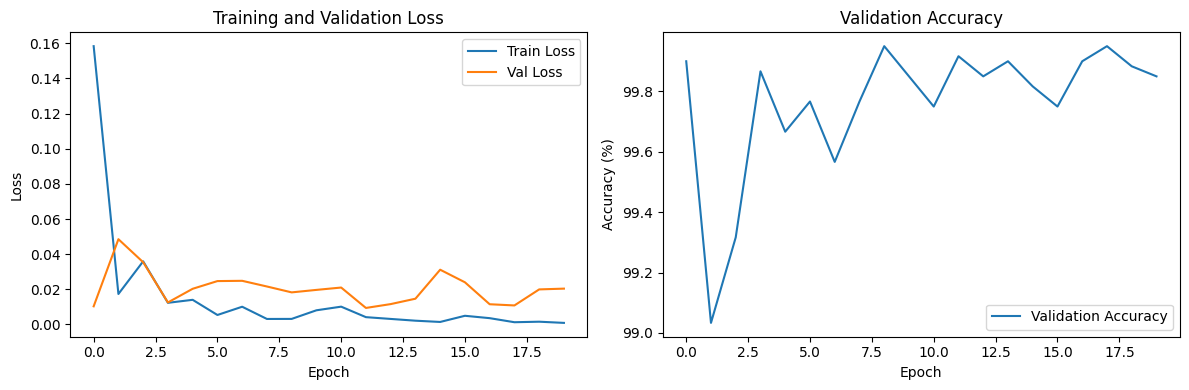

In [7]:
plt.figure(figsize=(12, 4))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Validation Accuracy")

plt.tight_layout()
plt.savefig("training_results.png")
plt.show()

## Model Inference

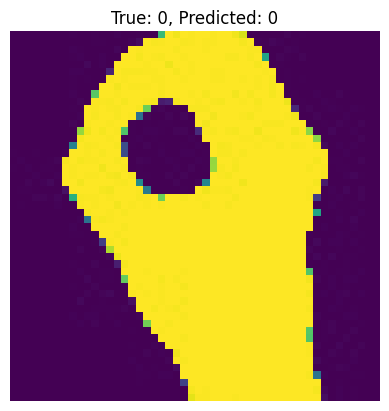

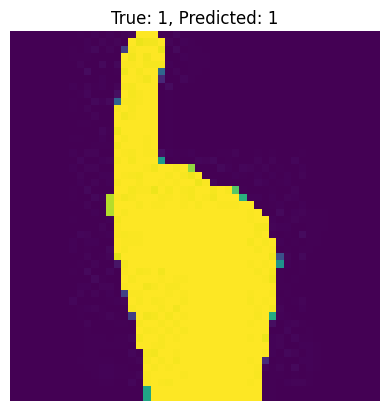

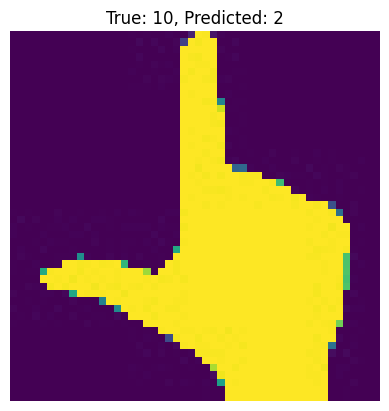

In [8]:
def predict_gesture(model, image_path, transform):
    """Predict the gesture class for a given image"""
    model.eval()
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        predicted_class = torch.argmax(output, dim=1).item()

    return predicted_class

# Test prediction on sample images
for class_name in sorted(os.listdir(TEST_DIR))[:3]:
    class_dir = os.path.join(TEST_DIR, class_name)
    if os.path.isdir(class_dir):
        sample_image = os.path.join(class_dir, os.listdir(class_dir)[0])
        predicted_class = predict_gesture(model, sample_image, transform)

        plt.figure()
        plt.imshow(Image.open(sample_image))
        plt.title(f"True: {class_name}, Predicted: {predicted_class}")
        plt.axis("off")
        plt.show()

## save model


In [9]:
# Ensure best model is saved
if os.path.exists("best_cnn_model.pth"):
    print("Best model saved as 'best_cnn_model.pth'")
    files.download("best_cnn_model.pth")  # Download in Colab
else:
    torch.save(model.state_dict(), "best_cnn_model.pth")
    files.download("best_cnn_model.pth")

Best model saved as 'best_cnn_model.pth'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>